In [2]:
func_dir = '/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/'
# ! pip install netCDF4 --user

In [3]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
sys.path.append('/global/home/users/ann_scheliga/.local/lib/python3.7/site-packages/xarray')
import xarray as xr
sys.path.append(func_dir)
import load_data
import time_series_calcs
import plotting_functions

In [4]:
fw = load_data.load_CYGNSS_05()
grace_dict = load_data.load_GRACE()
res_shp = load_data.load_GRanD()
precip = load_data.load_IMERG()

In [5]:
def reservoir_subset(dam_name,idx = 0):
    """
    Must have already run: `res_shp = load_data.load_GRanD()`

    Inputs
    ------
    dam_name : str
        name of dam in dataset
    idx : int
        default = 0
        use to select a specific dam by index if the dam name appears more than once
        ex: the dam name 'Pelican Lake' appears 4 times in the data. use idx = 3 to get the last occurrence

    Outputs
    -------
    coords_oi : tuple
        coordinates Of Interest
        form of (latitude , longitude)
        the given lat and lon values of the reservoir in the dataset
    """
    dam_row = (res_shp['DAM_NAME'].str.lower())==(dam_name.lower())
    n_rows = dam_row.sum()
    if n_rows == 0:
        print('Dam name not found')
    elif n_rows > 1 and (n_rows > idx):
        print('Dam name',dam_name,'is redundant.',n_rows,'entires found. Use idx input to help')
        dam_row = dam_row[dam_row].index[idx]
    elif n_rows <= idx:
        print('idx input too large. idx =',idx, 'for',n_rows, 'total dam rows')
    coords_oi = tuple(np.array(res_shp.loc[dam_row,['LAT_DD','LONG_DD']])[0])
    return coords_oi

In [6]:
def grace_point_subset(coords_i,buffer=0):
    """
    Must have already run: `grace_dict = load_data.load_GRACE()`
    
    Inputs
    ------
    coords_i: tuple of (lat,lon)

    buffer : float
        default = 0
        units of decimal degrees
        the extra length to extend the subset in a square from the central coordinate
    
    Outputs
    -------
    cmwe_i: pd.DataFrame
        GRACE cmwe solution of the mascon containing the input point
    mascon_i: pd.DataFrame
        GRACE mascon metadata of the mascon containing the input point
    
    """
    lat = coords_i[0]
    lon = coords_i[1]
    # Check if within longitude range
    lat_max = grace_dict['mascon']['lat_center'] + grace_dict['mascon']['lat_span']/2 + buffer
    lat_min = grace_dict['mascon']['lat_center'] - grace_dict['mascon']['lat_span']/2 - buffer
    lat_range = (lat>=lat_min) * (lat <= lat_max)
    # Check if within latitude range
    lon_max = grace_dict['mascon']['lon_center'] + grace_dict['mascon']['lon_span']/2 + buffer
    lon_min = grace_dict['mascon']['lon_center'] - grace_dict['mascon']['lon_span']/2 - buffer
    lon_range = (lon>=lon_min) * (lon <= lon_max)
    
    range_bool = lat_range * lon_range
    
    mascon_i = grace_dict['mascon'].loc[range_bool]
    cmwe_i = grace_dict['cmwe'].loc[mascon_i.index].squeeze()
    return cmwe_i , mascon_i

In [39]:
def precip_point_subset(coords_i):
    """
    Must have already run: `precip = load_data.load_IMERG()`
    """
    # Select data
    precip_xr = precip.sel(lat=coords_i[0],lon=coords_i[1],method='nearest')
    dates_precip = np.array(list(map(lambda x: pd.Timestamp('1980-01-06') + pd.DateOffset(seconds=x),precip_xr['time'].values)))
        # Time = seconds since 1980 Jan 06 (UTC), per original HDF5 IMERG file
    precip_ts = pd.Series(data=precip_xr,index=dates_precip)
    return precip_ts

In [7]:
def cygnss_point_subset(coords_i):
    """
    Must have already run: `fw = load_data.load_CYGNSS_05()`
    """
    # Select data
    fw_xr = fw.sel(lat=coords_i[0],lon=coords_i[1],method='nearest')
    dates_fw = np.array(list(map(lambda x: pd.Timestamp('2018-08-01') + pd.DateOffset(months=x),fw_xr['time'])))
    fw_ts = pd.Series(data=fw_xr,index=dates_fw)
    return fw_ts

In [117]:
def intersecting_timeframes(*series,buffer=1):
    series_start_list = [None] *  len(series)
    series_stop_list = [None] *  len(series)
    for idx , ts in enumerate(series):
        series_start_list[idx] = ts.index.min() + pd.DateOffset(months=-buffer)
        series_stop_list[idx] = ts.index.max() + pd.DateOffset(months=buffer)

    combined_start = max(series_start_list)
    combined_stop = min(series_stop_list)

    cropped_series_list = [None] * len(series)
    for idx , ts in enumerate(series):
        cropped_series_list[idx] = ts.loc[(ts.index >= combined_start) & (ts.index <= combined_stop)]
    return cropped_series_list
test = intersecting_timeframes_test(fw_series,cmwe_series)

In [114]:
test , test1 = intersecting_timeframes_test(fw_series,cmwe_series,buffer=2)
print(test.iloc[[0,-1]])

2018-10-01    10.20
2022-11-01     6.68
dtype: float32


In [115]:
def intersecting_2_timeframes(series1,series2,buffer=1):
    series1_start = series1.index.min() + pd.DateOffset(months=-buffer)
    series1_stop  = series1.index.max() + pd.DateOffset(months= buffer)
    series2_start = series2.index.min() + pd.DateOffset(months=-buffer)
    series2_stop  = series2.index.max() + pd.DateOffset(months= buffer)
    
    series1_intersect = series1.loc[(series1.index>=series2_start) & (series1.index<=series2_stop)]
    series2_intersect = series2.loc[(series2.index>=series1_start) & (series2.index<=series1_stop)]
    
    return series1_intersect , series2_intersect

In [ ]:
def three_part_timeseries(series0,series1,series2):
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=0.75)

    twin1 = ax.twinx()
    twin2 = ax.twinx()

    # Offset the right spine of twin2.  The ticks and label have already been
    # placed on the right by twinx above.
    twin2.spines.right.set_position(("axes", 1.2))

    p1, = ax.plot(series0, "b-", label="Density")
    p2, = twin1.plot(series1, "r-", label="Temperature")
    p3, = twin2.plot(series2, "g-", label="Velocity")


    ax.set_xlabel("Distance")
    ax.set_ylabel("Density")
    twin1.set_ylabel("Temperature")
    twin2.set_ylabel("Velocity")

    ax.yaxis.label.set_color(p1.get_color())
    twin1.yaxis.label.set_color(p2.get_color())
    twin2.yaxis.label.set_color(p3.get_color())

    tkw = dict(size=4, width=1.5)
    ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
    twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    ax.tick_params(axis='x', **tkw)

    ax.legend(handles=[p1, p2, p3])

    plt.show()

In [118]:
def single_timeseries_GRACE_CYGNSS(coords_i):
    """
    Description
    -----------
    Hard-coded time series slicing for CYGNSS to start two months after the intersecting_timeframes() start date
    
    Inputs
    ------
    coords_i: tuple of (lat,lon)
    
    Outputs
    -------
    
    """
    precip_full = precip_point_subset(coords_i)
    fw_full = cygnss_point_subset(coords_i)
    cmwe_full , mascon_ts = grace_point_subset(coords_i)
    
    precip , fw , cmwe = intersecting_timeframes(precip_full,fw_full,cmwe_full,buffer=0)
    print(precip.iloc[[0,-1]])
    print(fw.iloc[[0,-1]])
    print(cmwe.iloc[[0,-1]])
    fw = fw[2:]
    
    plt.figure(figsize=(12,6))
    
    ax0 = precip.plot(label='IMERG')
    ax1 = fw.plot(ax=ax0,label='CYGNSS',legend=True)
    ax2 = cmwe.plot(ax=ax0,secondary_y = True,label='GRACE',legend=True, color = 'k')
    
    ax1.set_ylabel('Fraction of water coverage')
    ax2.set_ylabel('water equivalence (cm)')
    return fw , cmwe

           slope   intercept   r_value   p_value   std_err
labels                                                    
1426   -0.043903   88.705977 -0.039623  0.563379   0.07586
1427    -0.12197  245.336515 -0.117468  0.085735  0.070652
1428   -0.089652  180.387377 -0.093474  0.172064  0.065429
1429    0.247977 -496.908976  0.199375  0.003326  0.083511
1430    0.111738 -223.571149  0.096674  0.157785  0.078825


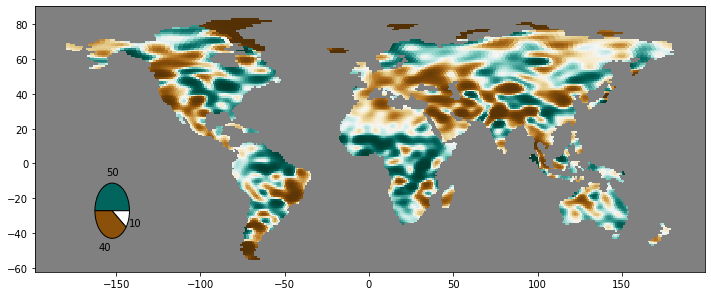

In [10]:
## Trying out plotting functionality

tws = grace_dict['cmwe'].T
x_tws= list(map(time_series_calcs.toYearFraction,tws.index))
y_tws = tws
initial_tws_slopes = time_series_calcs.linregress_wrap(x_tws,y_tws)
print(initial_tws_slopes.head())

initial_tws_slopes_gdf = gpd.GeoDataFrame(pd.concat([initial_tws_slopes , grace_dict['mascon']],axis=1))

fig , ax = plt.subplots(figsize=(12,8))
input_gdf = initial_tws_slopes_gdf
count = 0
plotting_functions.statsig_map(input_gdf,ax,count, pie_row = [0.5,0.4,0.1])

In [11]:
merowe = (18.68 , 32.06)
indirasagar = (22.18,76.6)
estreito = (-6.5 ,-47.0)

In [18]:
coords_oi = estreito
test = grace_point_subset(coords_oi)
print(test[1].iloc[0]['geometry'].exterior)
test[1]['geometry'].explore()

LINEARRING (-46.38655460000002 -6.5, -46.38655460000002 -7.5, -47.39495800000002 -7.5, -47.39495800000002 -6.5, -46.38655460000002 -6.5)


2018-08-01    0.051
2022-11-01    0.000
dtype: float64
2018-08-01    5.68
2022-11-01    6.68
dtype: float32
date_middle
2018-11-01     7.682659
2022-11-16    11.275423
Name: 10055, dtype: float64


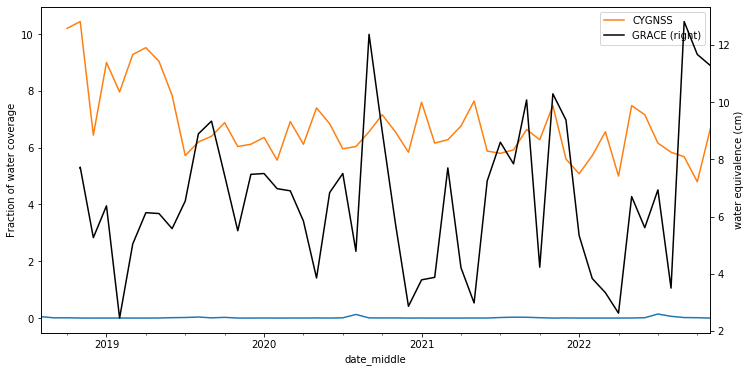

In [119]:
fw_series , cmwe_series = single_timeseries_GRACE_CYGNSS(merowe)

In [15]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction
fw_ts = fw_series
cmwe_ts = cmwe_series
fw_ts.index = list(map(toYearFraction,fw_ts.index))
cmwe_ts.index = list(map(toYearFraction,cmwe_ts.index))

In [16]:
fw_ts = time_series_calcs.TimeSeriesMetrics(fw_ts,'CYGNSS')
cmwe_ts = time_series_calcs.TimeSeriesMetrics(cmwe_ts,'GRACE')

In [17]:
len(fw_ts.ts) , len(cmwe_ts.ts)

(50, 50)